In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:

def get_weather_data(api_key, lat, lon):
    base_url = "https://history.openweathermap.org/data/2.5/history/city"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'type': 'hour',
        'start': '1699542000', #GMT: Thursday, 9 November 2023 15:00:00
        'end': '1702133999', #GMT: Saturday, 9 December 2023 14:59:59
    }

    response = requests.get(base_url, params=params)
    data = response.json()
    return data

def parse_weather_data(data, city_name):
    # (Your existing code for parsing weather data)
    # Modify the function to accept the city_name parameter
    timestamps = []
    temperatures = []
    feels_like = []
    temp_min = []
    temp_max = []
    pressure = []
    humidity = []
    weather_description = []
    wind_speed = []
    wind_deg = []
#     visibility = []

    for entry in data.get('list', []):
        timestamp = entry.get('dt', None)
        main = entry.get('main', {})
        temperature = main.get('temp', None)
        feels_like_val = main.get('feels_like', None)
        temp_min_val = main.get('temp_min', None)
        temp_max_val = main.get('temp_max', None)
        pressure_val = main.get('pressure', None)
        humidity_val = main.get('humidity', None)

        weather = entry.get('weather', [])[0]
        description = weather.get('description', None)

        wind = entry.get('wind', {})
        wind_speed_val = wind.get('speed', None)
        wind_deg_val = wind.get('deg', None)

#         visibility_val = entry.get('visibility', None)

        if timestamp is not None and temperature is not None:
            timestamps.append(timestamp)
            temperatures.append(temperature)
            feels_like.append(feels_like_val)
            temp_min.append(temp_min_val)
            temp_max.append(temp_max_val)
            pressure.append(pressure_val)
            humidity.append(humidity_val)
            weather_description.append(description)
            wind_speed.append(wind_speed_val)
            wind_deg.append(wind_deg_val)
#             visibility.append(visibility_val)

    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Temperature': temperatures,
        'Feels Like': feels_like,
        'Temp Min': temp_min,
        'Temp Max': temp_max,
        'Pressure': pressure,
        'Humidity': humidity,
        'Weather Description': weather_description,
        'Wind Speed': wind_speed,
        'Wind Degree': wind_deg,
#         'Visibility': visibility,
    })

    return df

def save_to_csv(df, filename='weather_data_history.csv'):
    # Save DataFrame to CSV
    df.to_csv(filename, index=False)
    print(f'Data saved to {filename}')

# api_key = '481eef4330155cda4dd9fc3b3e7abba9'
api_key = 'b4b5def1abe998b4aedbf73b592b0224'

# List of cities with their latitude and longitude
csv_file_path = '../data/cities_data.csv'

# Read the CSV file into a DataFrame
cities_df = pd.read_csv(csv_file_path)

# Create a list of dictionaries in the specified format
cities = []
for _, row in cities_df.iterrows():
    city_dict = {
        'name': row['name'],
        'latitude': str(row['latitude']),
        'longitude': str(row['longitude']),
    }
    cities.append(city_dict)

# Initialize an empty DataFrame to store the final data
final_df = pd.DataFrame()

# Fetch and parse weather data for each city
for city_info in cities:
    city_name = city_info['name']
    lat = city_info['latitude']
    lon = city_info['longitude']

    weather_data = get_weather_data(api_key, lat, lon)
#     print (weather_data['list'][0])
#     break
    city_df = parse_weather_data(weather_data, city_name)

#     Add a 'City' column to identify the city in the DataFrame
    city_df['City'] = city_name

#     Append the data for the current city to the final DataFrame
    final_df = pd.concat([final_df, city_df], ignore_index=True)

# Save the final DataFrame to a CSV file
save_to_csv(final_df, '../data/weather_data_combined.csv')

Data saved to ../data/weather_data_combined.csv


In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16900 entries, 0 to 16899
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            16900 non-null  int64  
 1   Temperature          16900 non-null  float64
 2   Feels Like           16900 non-null  float64
 3   Temp Min             16900 non-null  float64
 4   Temp Max             16900 non-null  float64
 5   Pressure             16900 non-null  int64  
 6   Humidity             16900 non-null  int64  
 7   Weather Description  16900 non-null  object 
 8   Wind Speed           16900 non-null  float64
 9   Wind Degree          16900 non-null  int64  
 10  City                 16900 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 1.4+ MB


In [4]:
# check duplicate row
index = final_df.index
detectDupSeries = index.duplicated(keep='first')
num_duplicated_rows = detectDupSeries.sum()
if num_duplicated_rows == 0:
    print(f"Your raw data have no duplicated line.!")
else:
    if num_duplicated_rows > 1:
        ext = "lines"
    else:
        ext = "line"
    print(f"Your raw data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data.!")

Your raw data have no duplicated line.!


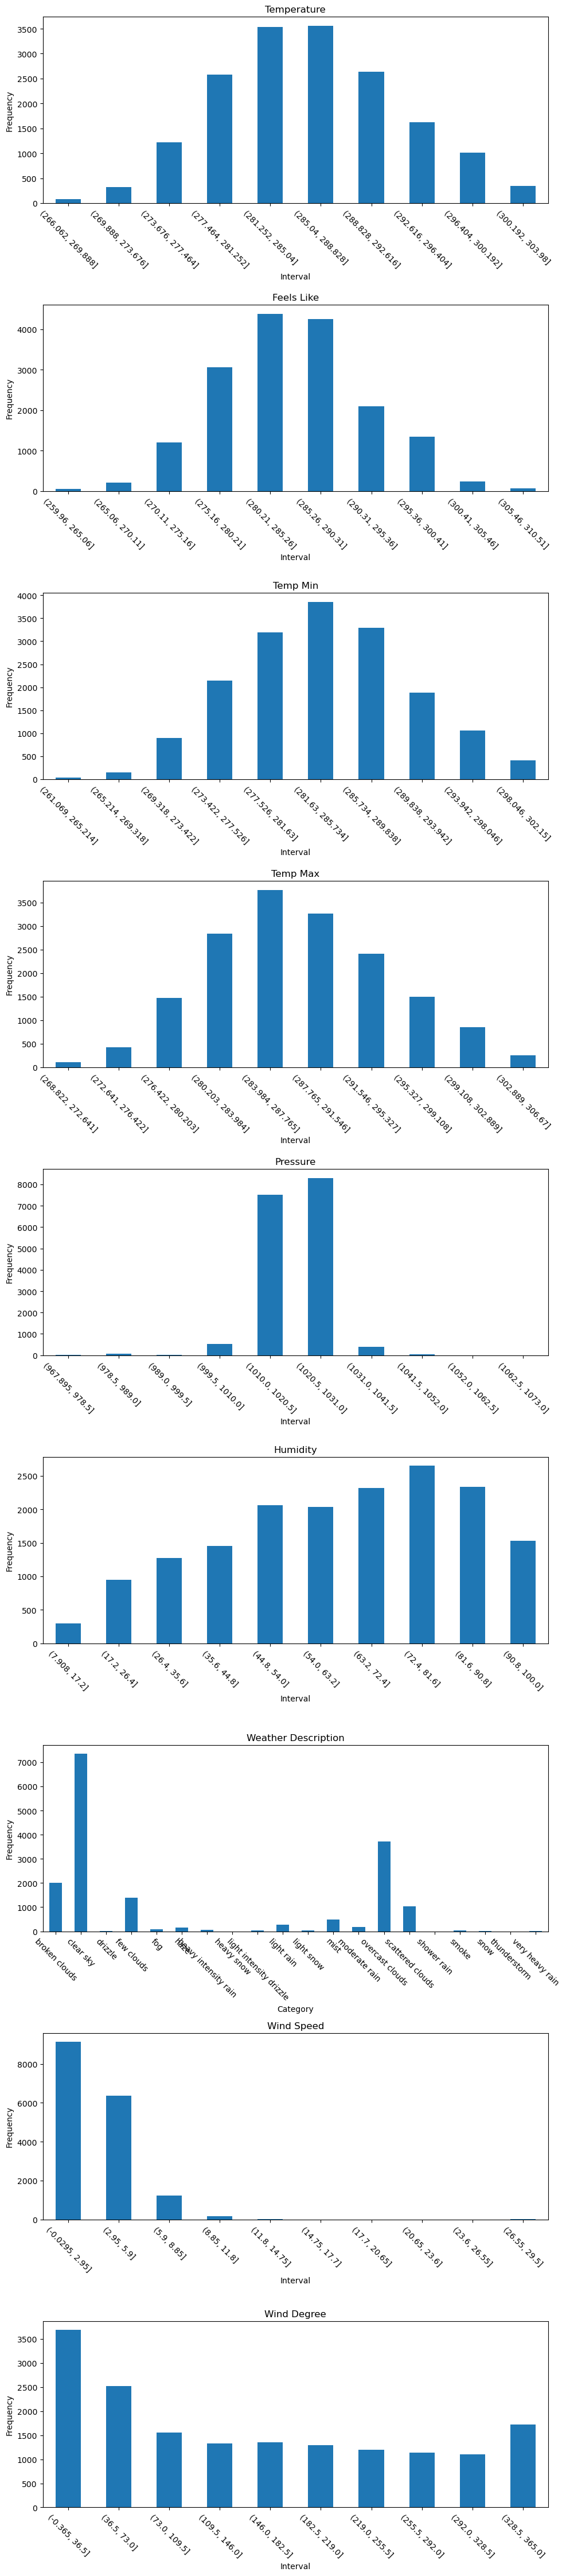

In [5]:
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(10, 45))

# Flatten the 2D array of axes into a 1D array
axes = axes.flatten()

# Iterate over each column and plot the line chart of frequencies
for i, column in enumerate(final_df.columns[1:10]):
    ax = axes[i]
    
    # Count the frequency of each interval
    try: 
        intervals = pd.cut(final_df[column], bins=10)
        interval_counts = intervals.value_counts().sort_index()
        interval_counts.plot(kind='bar', ax=ax)
        ax.set_title(column)
        ax.set_xlabel('Interval')
        ax.set_ylabel('Frequency')
    except:
        category_counts = final_df[column].value_counts().sort_index()
        category_counts.plot(kind='bar', ax=ax)
        ax.set_title(column)
        ax.set_xlabel('Category')
        ax.set_ylabel('Frequency')
    
    # Plot the line chart
    ax.tick_params(axis='x', rotation=-45)
#     ax.tick_params(axis='both', labelsize=10)
    

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()